# Artist Investigations

In [4]:
artist_name = "gorgon city".lower()
artist_frame = scrobbles[scrobbles["artist"].str.lower() == artist_name] # FILTER SCROBBLES
artist_frame = artist_frame.sort_index(ascending=False) # SORT
# artist_frame = artist_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = artist_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days
print(f'{artist_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

artist_frame.describe()[1:]

1,233 scrobbles
4 days spent listening since Nov. 2017
4.46 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.046042,0.714379,270745.820490,0.800026,0.346944,5.617338,0.134218,-7.078945,0.441331,0.054055,122.854020,3.995622,0.498696
std,0.084004,0.076841,77567.562426,0.096553,0.379047,3.463314,0.133318,1.108589,0.496764,0.022931,4.799479,0.066053,0.190035
min,0.000098,0.345000,179080.000000,0.257000,0.000000,0.000000,0.030300,-12.378000,0.000000,0.027700,69.942000,3.000000,0.039900
25%,0.005240,0.671000,216841.000000,0.744000,0.000643,3.000000,0.067600,-7.636000,0.000000,0.041100,121.982000,4.000000,0.327000
50%,0.013200,0.712000,235200.000000,0.798000,0.122000,6.000000,0.088000,-6.865000,0.000000,0.048600,123.951000,4.000000,0.520000
75%,0.043800,0.781000,291779.000000,0.880000,0.862000,9.000000,0.117000,-6.246000,1.000000,0.060800,124.998000,4.000000,0.668000
max,0.735000,0.843000,472444.000000,0.976000,0.919000,11.000000,0.676000,-4.063000,1.000000,0.151000,176.994000,4.000000,0.853000


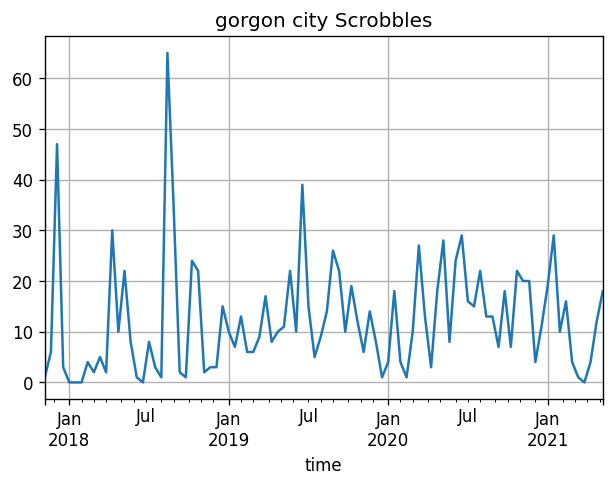

In [5]:
filtered_artist = scrobbles[scrobbles["artist"].str.lower() == artist_name]
# resample by day and mean
filtered_artist = filtered_artist.resample("2W").count()

filtered_artist["energy"].plot()

plt.title(f"{artist_name} Scrobbles")
plt.grid()
plt.show()

## Average Descriptor

Below presents the average descriptor for the artist. "*All Listened Tracks*" describes the descriptor based on the listening activity for this artist. This takes into account how many times a track is listened to. "*Distinct Tracks*" takes only the distinct set of tracks that have been listened to and takes that average.

The difference between them could be described as which features are preferred for an artist. If the blue bar is higher than the red, it would indicate that tracks from this artist which have a higher value for this are listened to more. 

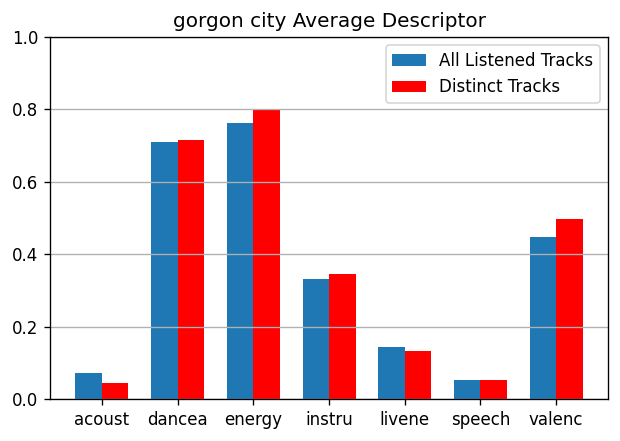

In [6]:
filtered_artist = scrobbles[scrobbles["artist"].str.lower() == artist_name]
filtered_artist_no_dup = filtered_artist.drop_duplicates(['uri'])

filtered_artist_no_dup = filtered_artist_no_dup.loc[:, float_headers].mean()
filtered_artist_dup = filtered_artist.loc[:, float_headers].mean()

x = np.arange(len(float_headers))
width = 0.35
plt.bar(x - width/2, filtered_artist_no_dup, width, label='All Listened Tracks')
plt.bar(x + width/2, filtered_artist_dup, width, label='Distinct Tracks', color=(1, 0, 0))

plt.title(f"{artist_name} Average Descriptor")
plt.legend(['All Listened Tracks', 'Distinct Tracks'])
plt.xticks(x, labels=[i[:6] for i in float_headers])
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

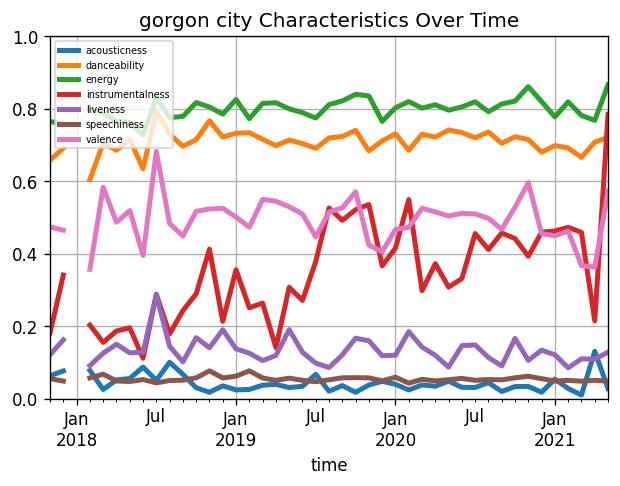

In [7]:
filtered_artist = scrobbles[scrobbles["artist"].str.lower() == artist_name]
# select only descriptor float columns
filtered_artist = filtered_artist.loc[:, float_headers]
# resample by day and mean
filtered_artist = filtered_artist.resample("1M").mean()

# filtered_playlist["energy"].plot()
filtered_artist.plot(lw=3)

plt.title(f"{artist_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Artist Listening Time

In [8]:
limit = 35
artists = fmnet.top_artists(period=fmnet.Range.OVERALL, limit=limit)

filtered_artists = [scrobbles[scrobbles["artist"] == i.name] for i in artists]

### STATS ###
# total time listening to artists 
artists_time = [i["duration_ms"].sum() for i in filtered_artists]
# total number of tracks
artists_track_count = np.array([i.drop_duplicates(["uri"]).count()[0] for i in filtered_artists])
# average length of artist's tracks (ms)
artists_average_track_length = np.array([i.drop_duplicates(["uri"])["duration_ms"].mean() for i in filtered_artists])

fig_size = (7,(5/20)*limit)

For these charts the ordering is left as retrieved from the API, i.e by most played.

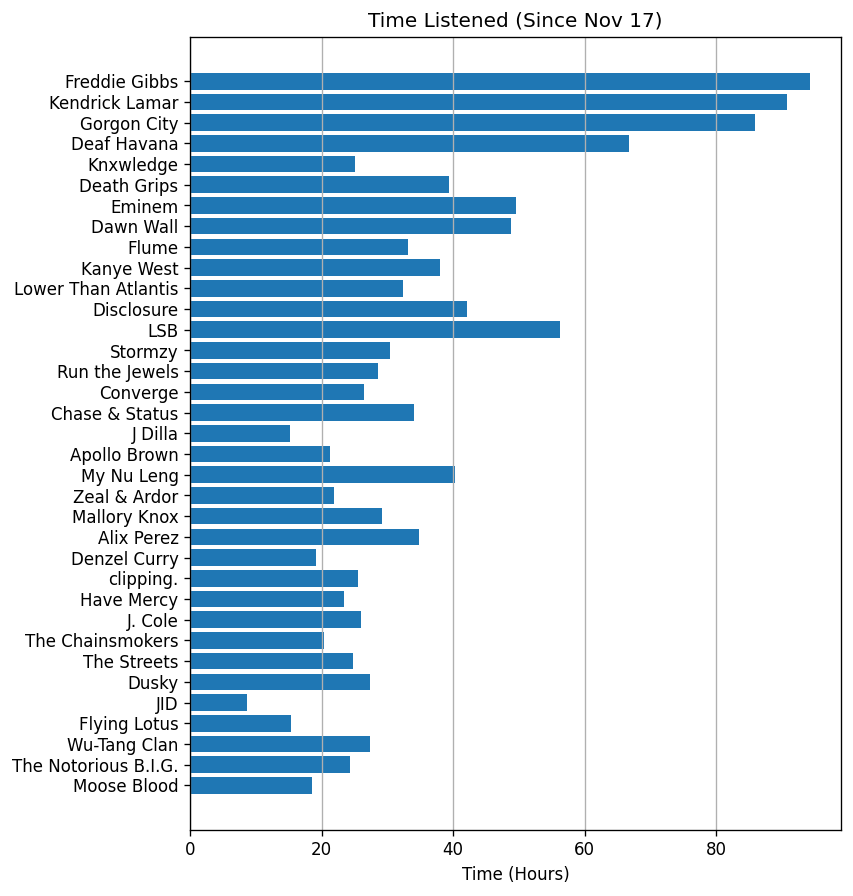

In [9]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(artists))[::-1], np.array(artists_time) / (1000 * 60 * 60) )
plt.yticks(np.arange(len(artists))[::-1], labels=[i.name for i in artists])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Listened (Since Nov 17)")
plt.show()

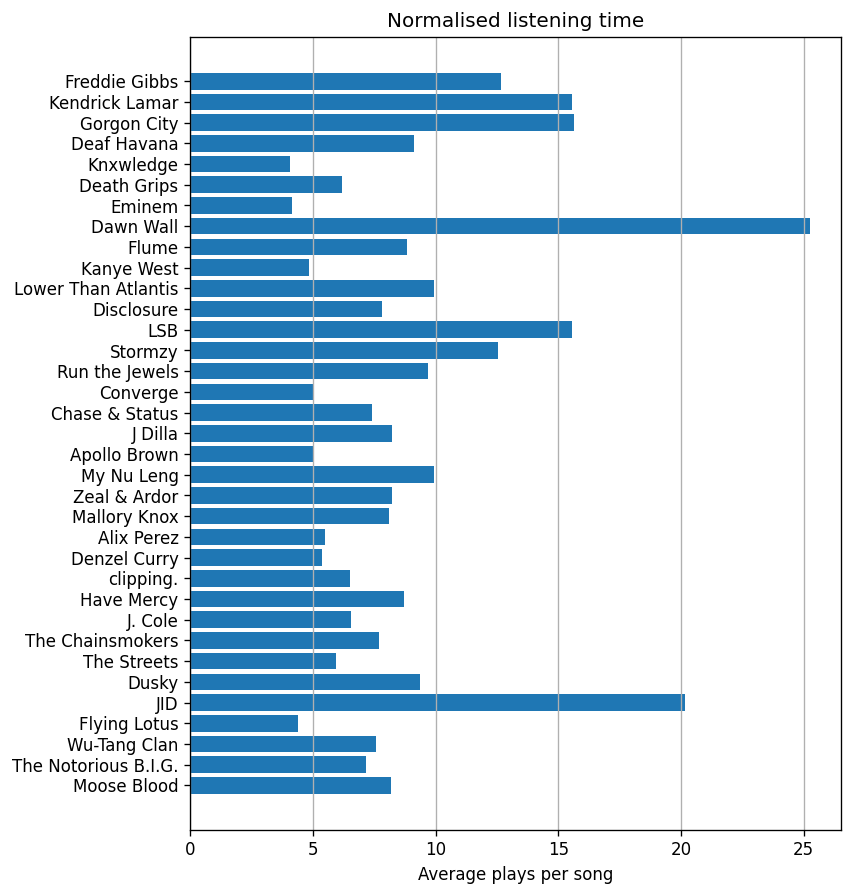

In [10]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(artists))[::-1], np.array(artists_time) / (artists_track_count * artists_average_track_length) )
plt.yticks(np.arange(len(artists))[::-1], labels=[i.name for i in artists])
plt.xlabel("Average plays per song")
plt.grid(axis="x")
plt.title("Normalised listening time")
plt.show()

# Imports & Setup

In [1]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [2]:
scrobbles = get_query(cache=cache)

query.csv not found, pulling


## Write Scrobble Frame

In [3]:
scrobbles.reset_index().to_csv(cache, sep='\t')